# MLB Pitch Velocity Gap Prediction Model

## Project Overview

This project aims to predict the **velocity differential (velocity gap)** between a pitcher's primary fastball and their breaking pitches — including **cutters, sliders, sweepers, slurves, and curveballs** — using pitch-level Statcast data from the 2020–2024 MLB regular seasons.

The target variable is defined as the **difference in velocity** between each breaking pitch and the pitcher’s average fastball velocity during the same season. For example, if a pitcher averages 95 MPH on fastballs and throws a curveball at 78 MPH, the velocity gap is -17 MPH.

## Objective

Build a model to predict this **velocity gap** based on available pitch characteristics, pitcher attributes, and contextual features. The goal is to uncover what factors contribute most to the speed differences between fastballs and breaking pitches, which may inform pitch design, scouting, or player development strategy.

## Table of Contents
1. Data Preprocessing & Feature Engineering
2. Exploratory Data Analysis (EDA)
3. Modeling Approach & Validation
4. Model Interpretation

## 1. Data Preprocessing & Feature Engineering Overview

**Objective:**
Build a clean and well-engineered training dataset from Statcast-style pitch-level data, in order to **predict the velocity differential between a pitcher's primary fastball and his breaking pitches** (CT, SL, SW, SV, CB).

#### Preprocessing Pipeline Summary

1. **Load Raw Data**
   Load full 2020–2024 MLB pitch-level data from CSV.

2. **Inspect Dataset and Identify Missing Fields**
   Use `df.info()` and `isnull()` to understand structure and check completeness.

3. **Drop Irrelevant Post-Contact Fields**  
   Remove columns like `exit_velo`, `launch_angle`, `spray_angle`, and `hit_spin_rate` because they reflect hitter outcomes and are not causally related to pitch design.

5. **Drop Rows Missing `release_velo`**
   Velocity is essential for our target variable; missing rows are removed.

6. **Hierarchical Imputation for Pitch Quality Metrics**
   Fill missing `spin_rate`, `break_x`, etc. using pitcher-season-pitch\_type mean, with fallback to league pitch type mean.

7. **Apply Domain-Based Range Filters**
   Filter out implausible pitch records using physically grounded ranges (velo, extension, break, angles, location).

8. **Normalize Lefty/Righty Coordinates**
   Mirror horizontal features (`release_x`, `break_x`, etc.) for LHPs so directional movement is consistent across handedness.

9. **Categorize Pitch Types**
   Create `pitch_group` column to assign broader pitch category labels for readability (not used in modeling).

10. **Identify Primary Fastball (FF or SI)**
   For each pitcher-season, define the most-used fastball type as the baseline. Compute its average velocity.

11. **Filter Pitcher-Seasons Based on Usage Volume**  
    Retain only pitcher-seasons with **at least 30 primary fastballs** thrown.  

12. **Filter Breaking Balls and Compute `velocity_diff`**
    Retain only breaking pitches (CT/SL/SW/SV/CB). Subtract average fastball velo to form target variable.

13. **Remove Rare Breaking ball Pitch-Type Instances**  
    Within each (pitcher, season), remove any specific breaking ball types with **fewer than 10 pitches**  
    to reduce noise and avoid overfitting due to under-sampled pitch types.

14. **Engineer Delta Features vs Fastball**
    For each breaking ball, compute the difference from the pitcher's average fastball in:

    * Release point, extension, spin, angles, movement, and location
    * Add `total_movement_diff` as combined movement difference metric
    * Add `spin_efficiency` (lift per spin) & `movement_angle` (horizontal vs vertical shape)

15. **Final Feature Selection**
    Choose 30+ features informed by baseball knowledge and ML relevance. Exclude identifiers, post-pitch outcomes, and label-derived fields.

16. **Export Final Dataset**
    Save the processed dataset as both `.csv` and `.parquet` for flexibility and efficient model training.

------

### Load Raw Statcast Dataset

We begin by reading in the raw CSV file provided for this project, which contains Statcast-style pitch tracking data from MLB seasons 2020 to 2024. This data includes features like pitch velocity, spin rate, movement, and location information for each pitch thrown.

Loading the data into a Pandas DataFrame allows us to inspect its structure, verify row count, and prepare it for further cleaning and processing.

In [4]:
import pandas as pd
import numpy as np

DATA_PATH = "Solutions Data Project - Data.csv"
df = pd.read_csv(DATA_PATH)
print(f"Raw rows: {len(df):,}")
df.head()

Raw rows: 3,108,206


,game_id,date,season,batter_id,batter,bats,pitcher_id,pitcher,throws,inning,...,release_z,extension,haa,vaa,hra,vra,exit_velo,launch_angle,spray_angle,hit_spin_rate
0,744801,2024-09-15,2024,660821,Jesus Sanchez,L,669022,MacKenzie Gore,L,1,...,5.9136,6.8211,2.8782,-10.4744,3.0823,-1.9942,NaN,NaN,NaN,NaN
1,744815,2024-08-22,2024,669911,Michael Toglia,R,571578,Patrick Corbin,L,6,...,6.1759,6.7402,4.7038,-7.6025,4.4530,-1.7285,NaN,NaN,NaN,NaN
2,744819,2024-08-08,2024,592192,Mark Canha,R,571882,Derek Law,R,8,...,6.6116,6.6238,-1.5109,-9.1573,-1.3716,-2.9818,85.353,-38.7048,-83.7756,4820.2248
3,744819,2024-08-08,2024,666464,Jerar Encarnacion,R,687792,DJ Herz,L,1,...,5.8143,6.7368,1.4409,-6.2436,4.5211,0.5503,NaN,NaN,NaN,NaN
4,744821,2024-08-05,2024,656305,Matt Chapman,R,674285,Eduardo Salazar,R,8,...,5.5856,6.7672,-4.0364,-7.8794,-3.0295,-1.9651,NaN,NaN,NaN,NaN


### Inspect Data Structure and Missing Values

* Confirm column names / dtypes.  
* Spot obvious missing‑data issues.

In [6]:
# Display the structure of the DataFrame including data types and non-null counts
df.info(show_counts=True)

# Identify and display the top 15 columns with the most missing values
print("\nMissing fields：")
df.isnull().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108206 entries, 0 to 3108205
Data columns (total 36 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   game_id          3108206 non-null  int64  
 1   date             3108206 non-null  object 
 2   season           3108206 non-null  int64  
 3   batter_id        3108206 non-null  int64  
 4   batter           3108206 non-null  object 
 5   bats             3108206 non-null  object 
 6   pitcher_id       3108206 non-null  int64  
 7   pitcher          3108206 non-null  object 
 8   throws           3108206 non-null  object 
 9   inning           3108206 non-null  int64  
 10  half_inning      3108206 non-null  object 
 11  tto              3108206 non-null  object 
 12  pitch_num        3108206 non-null  int64  
 13  balls            3108206 non-null  int64  
 14  strikes          3108206 non-null  int64  
 15  outs             3108206 non-null  int64  
 16  pitch_type       3

hit_spin_rate      2131953
exit_velo          2078791
launch_angle       2078067
spray_angle        2078065
spin_rate            21043
spin_direction       21042
extension             6372
release_velo           516
break_z                488
break_x                485
vra                    475
hra                    475
vaa                    475
induced_break_z        475
release_z              475
dtype: int64

------
### Drop Irrelevant Post-Contact Fields and Remove Rows Without Velocity

* We remove columns such as `exit_velo`, `launch_angle`, `spray_angle`, and `hit_spin_rate` because they represent **post-contact outcomes** driven by batter behavior. While technically not target leakage, they are **not causally related** to the pitch’s velocity design and therefore irrelevant to our goal.

* Our model aims to predict the **intended velocity gap** between fastballs and breaking balls — a feature rooted in pitch design (release, spin, movement), not what the hitter does with the ball.

* Additionally, since the target variable `velocity_diff` is computed from `release_velo`, we drop any rows that lack this field. Without a valid velocity, we cannot compute the label or include the row in training.

* We then re-check missing values to ensure data consistency before further processing.

In [8]:
# Drop batted‑ball outcome columns
DROP_COLS = ["exit_velo", "launch_angle", "spray_angle", "hit_spin_rate"]
df.drop(columns=DROP_COLS, inplace=True, errors="ignore")

In [9]:
# The target (velocity gap) and most pitch‑quality metrics depend on an accurate speed reading — rows without it cannot be salvaged.
df = df[df["release_velo"].notna()].copy()
print(f"Rows after dropping missing velo: {len(df):,}")

Rows after dropping missing velo: 3,107,690


In [10]:
# Re-check missing values
print("Missing fields：")
df.isnull().sum().sort_values(ascending=False).head(6)

Missing fields：


spin_rate         20567
spin_direction    20566
extension          5897
break_z              13
break_x              10
game_id               0
dtype: int64

-----
### Hierarchical Imputation for Critical Pitching Features with Missing Values

Several critical pitch-level features such as spin rate, spin direction, break, and extension have missing values due to sensor dropout or recording errors. Rather than dropping these rows, we perform a two-step imputation strategy to preserve valuable data:

1. **Primary Imputation (micro-group level):** Fill missing values using the mean of the same pitcher, same season, and same pitch type. This captures the most specific and contextual information available.
2. **Fallback Imputation (league level):** If a pitch type still has missing values (e.g., the pitcher threw very few of that type), fill using the league-wide mean for that pitch type.

This preserves row count while ensuring imputed values remain pitch- and context-relevant.

In [12]:
# Critical Features which has missing values
FILL_COLS = ["spin_rate", "spin_direction", "break_x", "break_z", "extension"]

# pitcher‑season‑pitch type micro‑group
group_keys = ["pitcher_id", "season", "pitch_type"]
for c in FILL_COLS:
    df[c] = df.groupby(group_keys)[c].transform(lambda s: s.fillna(s.mean()))

# fallback league mean per pitch type
for c in FILL_COLS:
    df[c] = df.groupby("pitch_type")[c].transform(lambda s: s.fillna(s.mean()))
    
# Check if any missing values remain 
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if missing_summary.empty:
    print("No missing values remain.")
else:
    print("Columns with remaining missing values:")
    print(missing_summary)

No missing values remain.


### Filter Out Physically Implausible or Corrupted Pitches

This step applies sanity checks to remove rows that contain likely corrupted or invalid values. These errors can occur due to sensor failures, ball tracking issues, or outlier events. We perform two types of filters:

1. **Logical Count Filter:**  
   We only retain pitches with a valid count state (balls ≤ 3 and strikes ≤ 2), excluding corrupted rows where the pitch count somehow exceeds rule constraints.

2. **Physics-Based Ranges:**  
   We retain only pitches with realistic values for velocity, spin, movement, release point, and angles. These bounds are based on domain knowledge from Statcast research and common MLB pitch characteristics:
   - `release_velo` between 45–106 mph
   - `break_x/z` within ±50 inches
   - `extension` between 4.5–8 feet
   - `haa/vaa/hra/vra` within physically observed angular ranges
   - Release and location values are restricted to the known bounds of the strike zone and mound geometry

By applying these filters, we reduce noise and remove broken rows without affecting valid pitches. The number of rows removed is reported below for traceability.

In [14]:
# Record original number of rows before filtering
before_rows = len(df)

# Convert "tto" text values (`"1st"`, `"2nd"`, etc.) into numeric values
df["tto"] = df["tto"].str.extract(r"(\d)").astype("Int64")

# Filter out corrupted pitch count scenarios or other impossible scenarios
df = df[(df.balls <= 3) & (df.strikes <= 2)]
df = df[df["tto"].between(1, 6)]
df = df[df["pitch_num"].between(1, 20)]
valid_bats = ["L", "R", "S"]
valid_throws = ["L", "R"]
df = df[df["bats"].isin(valid_bats) & df["throws"].isin(valid_throws)]

# Apply physical plausibility checks across multiple metrics
df = df[
    (df.release_velo.between(45, 106)) &
    (df.spin_direction.between(0, 360)) &
    (df.break_x.abs() <= 50) &
    (df.break_z.abs() <= 50) &
    (df.induced_break_z.between(-30, 30)) &
    (df.extension.between(4.5, 8.0)) &
    (df.location_x.between(-2.5, 2.5)) &
    (df.location_z.between(0, 6.0)) &
    (df.release_x.between(-7, 7)) &
    (df.release_z.between(3.8, 8.0)) &
    (df.haa.between(-10, 10)) &
    (df.vaa.between(-10, 0)) &
    (df.hra.between(-16, 16)) &
    (df.vra.between(-12, 12))
]

after_rows = len(df)

print(f"Before filter：{before_rows:,} rows")
print(f"After filter：{after_rows:,} rows")
print(f"Dropped {(before_rows-len(df)):,} rows ({(before_rows-len(df))/before_rows:.2%})")

Before filter：3,107,690 rows
After filter：2,811,370 rows
Dropped 296,320 rows (9.54%)


### Normalize Horizontal Features Across Pitcher Handedness

In Statcast data, horizontal metrics like `release_x`, `break_x`, and `location_x` are recorded relative to the pitcher's handedness. This means that a left-handed pitcher's release or break toward their glove side may appear opposite to a right-hander’s, even though the actual movement is functionally similar.

To standardize interpretation across left- and right-handed pitchers, we apply a mirroring transformation:
- For all left-handed pitchers (`throws == "L"`), we multiply horizontal features by -1.
- For right-handed pitchers, values remain unchanged.

We store the adjusted values in new columns (e.g., `release_x_adj`) to preserve the originals for optional use later.

This normalization ensures the model sees consistent directional patterns, allowing it to focus on *pitch behavior* rather than *handedness artifacts*.

In [16]:
# Identify left-handed pitchers
is_lefty = df.throws == "L"

# Define horizontal features that need to be mirrored for LHPs
X_FLIP_COLS = ["release_x", "break_x", "location_x", "haa", "hra"]

# For each horizontal feature, create a new column with mirrored values for LHPs
for c in X_FLIP_COLS:
    df[f"{c}_adj"] = df[c]                # Start by copying original values
    df.loc[is_lefty, f"{c}_adj"] *= -1    # Flip sign for left-handers only

### Create Pitch Category Labels (`pitch_group`)

This step creates a higher-level grouping for each pitch type by mapping `pitch_type` codes (e.g., 'FF', 'SL', 'CH') to human-readable categories (e.g., 'Fastball', 'Slider', 'Changeup').

The resulting `pitch_group` field provides clearer semantics and can be useful for:
- Exploratory Data Analysis (EDA)
- Visualizations or summary tables
- Optional grouping for model interpretability

However, in this project’s final modeling pipeline, this field is **not required** for training, since we will use `pitch_type` directly or encode it as part of categorical features.

This step is mostly for clarity and flexibility in case grouped pitch categories are needed later.

In [18]:
PITCH_MAP = {
    "FF": "Fastball", "SI": "Fastball",
    "CT": "Cutter",   "SL": "Slider",
    "SW": "Sweeper",  "SV": "Slurve",
    "CB": "Curveball","CH": "Changeup",
    "SP": "Splitter", "KN": "Knuckleball",
    "EP": "Eephus",   "AB": "Other", "UN": "Unknown"
}
df["pitch_group"] = df["pitch_type"].map(PITCH_MAP)

### Identify Each Pitcher’s Primary Fastball and Compute Its Average Velocity

To evaluate the velocity differential between a breaking ball and a pitcher's fastball, we must first determine **what pitch type counts as that pitcher’s “primary fastball.”**

In this step, we:
1. **Filter** the dataset to only include four-seamers (FF) and sinkers (SI) — the two common fastball types.
2. **Count** how many of each fastball type a pitcher throws in each season.
3. **Select** the most frequently used one as their primary fastball for that season.
4. **Merge** the corresponding average `release_velo` of that primary fastball as a reference for computing velocity gaps later.

This method allows us to account for the fact that some pitchers rely primarily on sinkers instead of four-seamers — we define \"primary\" based on usage, not pitch label.

In [20]:
# Filter fastballs only (four-seam FF and sinker SI)
fb = df[df.pitch_type.isin(["FF", "SI"])]

# Count number of each fastball type per pitcher and season
fb_ct = (fb.groupby(["pitcher_id", "season", "pitch_type"])
           .size().reset_index(name="n"))

# For each pitcher-season, select the most-used fastball type
primary_type = (fb_ct.sort_values(["pitcher_id", "season", "n"], ascending=False)
                      .drop_duplicates(["pitcher_id", "season"])
                      .rename(columns={"pitch_type":"primary_fastball"}))

# Compute average velocity of each fastball type per pitcher-season
fb_mean_velo = (fb.groupby(["pitcher_id", "season", "pitch_type"])
                  ["release_velo"].mean().reset_index())

# Merge primary fastball label with its average velocity
primary_fb = (primary_type
              .merge(fb_mean_velo,
                     left_on=["pitcher_id","season","primary_fastball"],
                     right_on=["pitcher_id","season","pitch_type"],
                     how="left")
              .drop(columns="pitch_type")
              .rename(columns={"release_velo":"primary_fastball_velo"}))

### Filter Pitcher-Seasons with Sufficient Sample Size for Modeling

To ensure statistical reliability and prevent noisy targets, we apply a thresholds before modeling:

1. **Primary Fastball Usage ≥ 30 Pitches**
   After determining each pitcher's primary fastball type (the most frequently thrown among FF and SI), we calculate how many times they threw it in a given season.
   We only retain pitcher-season combinations with **at least 30 pitches** of their primary fastball.
   This ensures that the computed average fastball velocity used for comparison is based on a representative sample.

Applying these filters ensures that our model is trained only on **reliable, interpretable, and statistically meaningful examples**, improving both **model robustness** and **domain credibility** in a professional baseball R\&D context.

In [22]:
# Primary fastball count
fb_counts = fb_ct.rename(columns={"n": "primary_fastball_count"})

# Merge primary fastball count into primary_fb
before_filter = len(primary_fb)
primary_fb = primary_fb.merge(
    fb_counts[["pitcher_id", "season", "pitch_type", "primary_fastball_count"]],
    left_on=["pitcher_id", "season", "primary_fastball"],
    right_on=["pitcher_id", "season", "pitch_type"],
    how="left"
).drop(columns=["pitch_type"])  

# Retain pitcher‑seasons with ≥ 30 primary fastball count
primary_fb = primary_fb[primary_fb["primary_fastball_count"] >= 30].copy()

after_filter = len(primary_fb)

print(f"Dropped pitcher-seasons with <30 primary FB: {before_filter - after_filter:,} pitcher-season groups")

Dropped pitcher-seasons with <30 primary FB: 536 pitcher-season groups


### Filter Breaking Balls and Compute Target Variable: `velocity_diff`

Now that we’ve identified each pitcher’s primary fastball and its average velocity, we turn our attention to the breaking balls. We:

1. **Filter** the dataset to keep only the five breaking ball types specified in the project:  
   Cutter (CT), Slider (SL), Sweeper (SW), Slurve (SV), and Curveball (CB).
2. **Merge** each breaking pitch with the corresponding pitcher's primary fastball average velocity, based on `pitcher_id` and `season`.
3. **Compute the target variable** `velocity_diff`, which is defined as: **velocity_diff = breaking_ball_velocity - primary_fastball_velocity**


This target captures the MPH difference between the current breaking ball and the pitcher’s average fastball — the value we aim to predict in our machine learning model.

In [24]:
# Define the five breaking ball pitch types per project spec
BRK_TYPES = ["CT", "SL", "SW", "SV", "CB"]

# Keep only breaking balls from the full dataset
bb = df[df.pitch_type.isin(BRK_TYPES)].copy()

print(f"Breaking ball subset size: {len(bb):,} rows")

# Merge primary fastball information (per pitcher-season) into breaking ball rows
bb = bb.merge(primary_fb, on=["pitcher_id","season"], how="inner")

print(f"Breaking ball rows after merge: {len(bb):,} rows (dropped pitcher-seasons with <30 primary FBs)")

# Compute the target: velocity difference between breaking ball and primary fastball
bb["velocity_diff"] = bb["release_velo"] - bb["primary_fastball_velo"]

Breaking ball subset size: 919,826 rows
Breaking ball rows after merge: 898,038 rows (dropped pitcher-seasons with <30 primary FBs)


### Drop Rare Breaking Ball Types (Pitch-Type-Level Filter)

Even if a pitcher-season has enough total breaking balls (≥10), some individual pitch types (e.g., slider, curve) may appear only a few times.
To reduce noise from underrepresented pitch types, we **require at least 10 pitches per pitch type** per pitcher-season.

In this step:

* We group the data by `pitcher_id`, `season`, and `pitch_type`, and count how many pitches exist in each group.
* We drop rows for any pitch type within a pitcher-season that appears **fewer than 10 times**.
* This ensures that model comparisons across pitch types (like slider vs. curve) are based on sufficient samples.

This is especially useful for avoiding misleading trends from pitches that were only used a handful of times.

In [26]:
# Set a per-pitch-type minimum sample threshold (10 pitches)
MIN_PITCH_TYPE_COUNT = 10

# Count pitch_type samples within each (pitcher_id, season, pitch_type)
bb_counts = (
    bb.groupby(["pitcher_id", "season", "pitch_type"])
      .size().reset_index(name="n_pitch_type")
)

# Only keep (pitcher, season, pitch_type) combinations with at least 10 pitches
bb = bb.merge(bb_counts, on=["pitcher_id", "season", "pitch_type"], how="left")
before_filter = len(bb)
bb = bb[bb["n_pitch_type"] >= MIN_PITCH_TYPE_COUNT].copy()

# Optionally drop the count column afterward
bb.drop(columns=["n_pitch_type"], inplace=True)

# Report
after_filter = len(bb)
print(f"Dropped rows: {before_filter - after_filter:,} (breaking ball types with <{MIN_PITCH_TYPE_COUNT} pitches)")
print(f"Remaining rows: {after_filter:,}")

Dropped rows: 3,722 (breaking ball types with <10 pitches)
Remaining rows: 894,316


### Engineer Differential Features Compared to Primary Fastball

To help the model learn **how each breaking pitch deviates from the pitcher's primary fastball**, we compute a set of relative difference features. This provides context-aware information that mimics how coaches evaluate pitch deception.

Here’s the process:

1. **Select baseline fastball features** to compare against:
   - Includes release point (`release_x_adj`, `release_z`), extension, spin rate, approach angles (e.g. `vaa`), movement metrics (`break_x_adj`, `induced_break_z`), and spatial location.
2. **Group by pitcher and season**, compute the average of those features for fastballs (FF or SI).
3. **Merge these baseline values** into the breaking ball DataFrame.
4. **Compute the difference** between each breaking pitch and the pitcher's seasonal fastball average for the same metric. For example:
   - `spin_rate_diff = breaking_ball_spin_rate - fastball_spin_rate`
   - `release_x_diff = breaking_ball_release_x_adj - fastball_release_x_adj`
5. **Create a combined movement differential**, `total_movement_diff`, which is the Euclidean norm of the horizontal and vertical break deltas: `total_movement_diff = sqrt(break_x_diff² + induced_break_z_diff²)`
6. **Add domain-driven features** derived from baseball physics:
   * `spin_efficiency`: Defined as `abs(induced_break_z) / spin_rate`, this measures how effectively spin translates into movement — high-efficiency pitches may require less velocity separation.
   * `movement_angle`: Computed via `arctan2(break_x_adj, break_z)`, this represents the pitch’s movement orientation. It helps distinguish between horizontally sweeping sliders and vertically dropping curveballs.

These engineered features allow the model to focus on the *relative shape and deception* of the pitch, rather than raw values that may vary wildly between pitchers.

In [28]:
# List of fastball-related features to use as comparison baseline
BASE_COLS = [
    "release_x_adj", "release_z", "extension",
    "spin_rate", "vaa", "break_x_adj", "induced_break_z",
    "spin_direction", "haa_adj", "hra_adj",
    "location_x_adj", "location_z"
]

# Compute average fastball baseline values for each pitcher and season
fb_baseline = (fb.groupby(["pitcher_id","season"])[BASE_COLS]
                 .mean().reset_index()
                 .rename(columns={c: f"fb_{c}" for c in BASE_COLS}))

# Merge fastball baseline features into breaking ball dataset
bb = bb.merge(fb_baseline, on=["pitcher_id","season"], how="left")

# Compute the difference between breaking ball and fastball baseline for each feature
for c in BASE_COLS:
    bb[f"{c.replace('_adj','')}_diff"] = bb[c] - bb[f"fb_{c}"]

# Add total movement differential from horizontal and vertical break differences
bb["total_movement_diff"] = np.sqrt(
    bb["break_x_diff"]**2 + bb["induced_break_z_diff"]**2
)

# Add spin_efficiency = abs(induced_break_z) / spin_rate
bb["spin_efficiency"] = bb["induced_break_z"].abs() / bb["spin_rate"]

# Add movement_angle = arctangent of horizontal vs vertical break
bb["movement_angle"] = np.arctan2(bb["break_x_adj"], bb["break_z"])

### Final Feature Selection and Train Set Assembly

In this step, we define the final set of features that will be used to train our regression model to predict `velocity_diff` — the MPH gap between a breaking ball and the pitcher's primary fastball.

#### Why These Features Were Chosen

We selected features based on a combination of:
- **Baseball knowledge** about what affects pitch deception and delivery
- **Data availability and reliability**
- **Avoiding target leakage** (only use info known *before* the pitch is thrown)

**Grouped by type:**

1. **Categorical / Contextual Features:**
   - `pitch_type`: the breaking ball identity (CT, SL, etc.)
   - `throws`: pitcher handedness
   - `balls`, `strikes`, `pitch_num`, `tto`, `inning`, `half_inning`, `outs`: context features that influence pitch selection and mechanics

2. **Raw Physical Features (statcast measurements):**
   - `spin_rate`, `spin_direction`: fundamental to pitch shape
   - `break_z`, `induced_break_z`, `break_x_adj`: key components of pitch movement
   - `release_z`, `extension`: used in calculating perceived velocity
   - `vaa`, `vra`, `haa_adj`, `hra_adj`: approach and release angles
   - `location_x_adj`, `location_z`: target location of pitch

3. **Differential Features (vs. primary fastball):**
   - Captures how this breaking ball differs from the pitcher's average fastball in release, spin, break, angles, and movement
   - Examples: `release_x_diff`, `spin_rate_diff`, `total_movement_diff`
   - These help the model learn the *deviation profile* that defines a pitch’s deception or intent

4. **Domain-Informed Derived Features:**

   * `spin_efficiency`: defined as `abs(induced_break_z) / spin_rate`, approximates how efficiently spin is converted into vertical movement (used in biomechanics and pitch design)
   * `movement_angle`: computed as `arctan2(break_x_adj, break_z)`, distinguishes between horizontally sweeping pitches and vertical drop pitches (e.g., sweeper vs. 12–6 curve)

#### Features Deliberately Excluded
- `pitcher_id`, `season`: Used only during exploratory analysis (e.g., group-based statistics, outlier detection). It was **explicitly removed prior to model training** to avoid identity leakage, which could lead the model to memorize pitcher-specific tendencies instead of learning generalizable physical patterns.
- `batter_id`, or `game_id`: would leak identity info and limit generalization
- `primary_fastball_velo`: part of how target was constructed — would leak label

Finally, we drop any remaining rows with missing values and assemble the training dataset.

In [30]:
FEATURES = [
    # Categorical / context features
    "pitch_type","throws","balls","strikes","pitch_num",
    "tto","inning","half_inning","outs",
    # Raw physical features
    "spin_rate","spin_direction","break_z","induced_break_z",
    "release_z","extension","vaa","vra",
    "break_x_adj","release_x_adj","haa_adj","hra_adj",
    "location_x_adj","location_z",
    # Differential features vs. fastball
    "release_x_diff","release_z_diff","extension_diff",
    "spin_rate_diff","vaa_diff","break_x_diff","induced_break_z_diff",
    "spin_direction_diff","haa_diff","hra_diff",
    "location_x_diff","location_z_diff","total_movement_diff",
    # Domain-driven engineered features
    "spin_efficiency", "movement_angle"
]

# Keep only selected features and target, and include season & pitcher_id for EDA, drop rows with missing values
train_df = bb[["season"] + ["pitcher_id"] + FEATURES + ["velocity_diff"]].dropna().reset_index(drop=True)

print(f"Train rows: {len(train_df):,}")
train_df.head()

Train rows: 894,316


,season,pitcher_id,pitch_type,throws,balls,strikes,pitch_num,tto,inning,half_inning,...,induced_break_z_diff,spin_direction_diff,haa_diff,hra_diff,location_x_diff,location_z_diff,total_movement_diff,spin_efficiency,movement_angle,velocity_diff
0,2024,571578,CT,L,0,0,1,3,6,Top,...,-7.607898,10.192153,-3.623374,-0.904793,-1.744466,-0.468526,16.257947,0.001577,-3.099203,-3.928876
1,2024,571578,SL,L,0,0,1,2,4,Top,...,-10.559998,93.003553,-2.608074,0.864607,-0.490966,-0.132626,21.188182,0.000399,-3.015410,-12.104676
2,2024,571578,CT,L,0,1,2,1,2,Bottom,...,-7.739098,-2.628847,-2.744274,-0.088593,-0.906366,-0.596026,16.017374,0.001669,-3.109682,-2.814376
3,2024,571578,CT,L,0,0,1,1,2,Bottom,...,-5.198498,95.966153,-2.004474,0.232907,-0.517966,-0.011426,12.902450,0.002677,3.103877,-7.389876
4,2024,571578,SL,L,0,2,3,2,4,Bottom,...,-12.172198,103.024653,-2.229974,0.638607,-0.354966,-0.784326,19.441091,0.000327,-3.089858,-9.570676


#### Save the fully cleaned and feature-engineered dataset in both `.csv` and `.parquet` formats for flexibility and downstream use.

In [32]:
train_df.to_csv("train_preprocessed.csv", index=False)
train_df.to_parquet("train_preprocessed.parquet", index=False)

--------
## 2. Exploratory Data Analysis (EDA) Overview

**Objective:**
Explore relationships between engineered features and the target variable `velocity_diff` — the **gap between breaking ball velocity and primary fastball velocity** — to validate feature quality, detect data leakage, and derive domain insights for model training.



### EDA Pipeline Summary

1. **Inspect Feature Distribution**
   Use `df.describe()` to examine basic statistics across all numeric features. Noted that `spin_efficiency` is **strongly right-skewed** and highly concentrated near 0, suggesting possible transformation (e.g., `log1p`, `QuantileTransformer`) to enhance model learning.

2. **Check for Data Leakage**
   Validated that all features are computed **prior to pitch release**. Computed Pearson correlation with `velocity_diff` confirms that top features (e.g., `break_z`, `vaa_diff`, `spin_efficiency`) are physically interpretable and causally consistent — no leakage from target or post-contact data.

3. **Correlation with Target Variable (`velocity_diff`)**

   * **Strong positive correlation** with movement-related features like `break_z`, `induced_break_z`, and `break_x_adj`.
   * **Strong negative correlation** with `total_movement_diff` due to its squared magnitude definition.
   * **Minimal correlation** from context variables (balls, strikes, inning), suggesting limited predictive power.

4. **Spearman Correlation Matrix**

   * Used Spearman (monotonic) correlation to account for **nonlinear relationships** in pitch data.
   * Reinforced earlier findings: movement features and delta metrics are most informative.
   * No severe multicollinearity detected; retained closely related pairs like `break_z` vs `induced_break_z` for interpretability.

5. **Velocity Gap by Pitch Type**

   * Boxplot of `velocity_diff` by pitch type shows:

     * **CB, SW, SV** have the **largest average gaps** (\~11–12 mph).
     * **CT (Cutter)** has smallest gap (\~6 mph), aligning with its hybrid nature.
   * Dashed line highlights league average (\~8.3 mph), aiding comparative interpretation.

6. **Velocity Gap vs Movement Characteristics**

   * Scatter plots show `velocity_diff` increases with greater:

     * **Horizontal break (`break_x_adj`)**
     * **Induced vertical break (`induced_break_z`)**
   * Hue by pitch type confirms **consistent trends across pitch classes**.

7. **Velocity Gap > 0 Sanity Check**

   * Identified 7,528 cases where `velocity_diff > 0` (breaking ball faster than fastball).
   * 99.4% are **cutters (CT)** — expected.
   * Remaining 48 cases are **sliders (SL)**, likely due to pitch classification noise.
   * Decision: **retain** these rows due to their low frequency and physical plausibility.

8. **Extension Difference vs Velocity Gap**

   * Analyzed `extension_diff` to evaluate release deception.
   * Observed **U-shaped LOWESS trend**: when extension mimics the fastball, velocity gap is minimized; mismatches in extension increase the gap.
   * Supports theory of tunneling and deception.

9. **Spin Efficiency vs Velocity Gap**

   * Explored how **efficient spin (|induced break z| / spin rate)** affects velocity gap.
   * LOWESS curve reveals **slight inverse relationship** within low efficiency range (< 0.01), suggesting that better spin conversion may disguise velocity gap.
   * Visual confirmation for inclusion of `spin_efficiency` in modeling.

In [34]:
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

# print(f"Rows: {len(train_df):,}   Columns: {train_df.shape[1]}")
# display(train_df.head())
display(train_df.drop(columns=["pitcher_id", "season"]).describe(percentiles=[.01, .25, .5, .75, .99]))

,balls,strikes,pitch_num,tto,inning,outs,spin_rate,spin_direction,break_z,induced_break_z,release_z,extension,vaa,vra,break_x_adj,release_x_adj,haa_adj,hra_adj,location_x_adj,location_z,release_x_diff,release_z_diff,extension_diff,spin_rate_diff,vaa_diff,break_x_diff,induced_break_z_diff,spin_direction_diff,haa_diff,hra_diff,location_x_diff,location_z_diff,total_movement_diff,spin_efficiency,movement_angle,velocity_diff
count,894316.000000,894316.000000,894316.000000,894316.0,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000,894316.000000
mean,0.835330,0.934594,2.908026,1.46657,5.069887,1.004008,2426.501066,147.309468,-34.798450,2.745598,5.777478,6.327904,-7.408364,-0.867492,-5.893115,1.944679,-3.095194,-1.979090,-0.368963,2.079178,0.103125,-0.036746,-0.065212,176.581725,-2.219517,-15.590054,-10.651992,-49.450893,-2.123124,0.830577,-0.432326,-0.567634,20.079164,0.001981,-2.350625,-8.293535
std,0.931597,0.829359,1.734462,0.700343,2.569707,0.816010,258.203983,83.351615,7.405920,5.177167,0.470897,0.451516,1.277092,1.183073,5.530123,0.717772,1.299769,1.158743,0.794163,0.850837,0.254263,0.171260,0.193293,234.034442,1.364242,6.730749,6.465975,107.127074,1.135826,1.027258,0.802816,0.872716,6.360319,0.001569,1.822042,3.568870
min,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,13.923000,0.002900,-49.999600,-15.476500,3.800000,4.500000,-10.000000,-5.825900,-34.067800,-1.181000,-9.358100,-7.428500,-2.499900,0.000000,-1.489354,-2.343462,-2.448429,-2495.405699,-6.386044,-50.630862,-31.901673,-257.663608,-7.420999,-3.582568,-3.235161,-3.223222,0.202463,0.000000,-3.141593,-23.244048
1%,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,1842.316245,18.923705,-49.241600,-8.690700,4.440615,5.299200,-9.840185,-3.565185,-20.167885,0.342215,-6.425000,-4.682300,-2.134385,0.284600,-0.544663,-0.500101,-0.533731,-368.756993,-4.929272,-33.723627,-24.577300,-199.792382,-5.004392,-1.302757,-2.222271,-2.432507,7.152656,0.000031,-3.135381,-15.764682
25%,0.000000,0.000000,1.000000,1.0,3.000000,0.000000,2257.767700,70.431350,-40.258800,-0.886800,5.498575,6.022500,-8.346100,-1.673725,-8.852825,1.460500,-3.917500,-2.756800,-0.913500,1.482000,-0.046510,-0.137394,-0.183189,32.102593,-3.202110,-19.340304,-15.196042,-144.463249,-2.844483,0.115586,-0.979926,-1.176669,15.568400,0.000781,-3.043988,-10.896050
50%,1.000000,1.000000,3.000000,1.0,5.000000,1.000000,2421.047400,148.440150,-35.011900,2.693300,5.800400,6.337200,-7.477400,-0.874000,-4.758900,1.915400,-3.037200,-1.979400,-0.390900,2.049500,0.097213,-0.032550,-0.065130,168.142619,-2.309358,-14.588250,-10.915739,-54.137079,-2.075119,0.761974,-0.451909,-0.591730,19.418637,0.001661,-2.967388,-8.513639
75%,1.000000,2.000000,4.000000,2.0,7.000000,2.000000,2591.177350,196.938975,-29.569575,6.339800,6.094300,6.626400,-6.552500,-0.070600,-2.116900,2.413300,-2.209700,-1.199200,0.153200,2.638600,0.247953,0.068767,0.051502,315.235455,-1.329754,-10.927549,-6.431390,3.826457,-1.351397,1.474463,0.095253,0.009914,24.183821,0.002874,-2.833085,-5.750235
99%,3.000000,2.000000,8.000000,3.0,10.000000,2.000000,3044.660780,335.130935,-17.360200,14.942170,6.826285,7.409385,-4.262315,1.905285,4.651425,3.737185,-0.256115,0.717900,1.584085,4.193000,0.782035,0.373309,0.425473,772.620570,1.218486,-2.844049,4.941468,198.155562,0.375503,3.525445,1.536335,1.582073,35.514458,0.006423,3.134729,-0.194339
max,3.000000,2.000000,18.000000,4.0,16.000000,2.000000,3599.944900,359.995600,1.748700,29.975300,7.386700,7.999800,-0.668400,4.494600,22.483800,4.803200,2.621800,3.601000,2.499100,5.998000,2.389107,1.367007,1.919909,1617.782092,4.517487,12.065995,18.097914,254.504750,

#### Spin Efficiency Distribution Note

The feature `spin_efficiency` is calculated as the ratio of induced vertical break to raw spin rate. Upon inspection, its values are highly concentrated near zero, showing a strong right-skewed distribution. This skewness may reduce the model’s ability to effectively learn from the subtle variations in spin efficiency.

-----


### Data Leakage Check

To ensure the model does not learn from any **target-derived or post-contact outcome**, we validated the feature set for potential data leakage:

* The target variable, `velocity_diff`, represents the **gap between the current breaking ball and the pitcher's average primary fastball velocity**.

As a sanity check, we computed the Pearson correlation matrix:
The most highly correlated features (e.g., `break_z`, `vaa_diff`, `spin_rate_diff`) are physically interpretable and causally consistent with pitch design.

**Conclusion:**

> Our feature set has been thoroughly validated and does **not contain any data leakage** from the target variable. All top correlated features are either raw or delta values computed solely from pre-release pitch metrics, which confirms that the label velocity_diff is not implicitly embedded in the features.


In [37]:
cols_to_drop = ["pitcher_id", "season"]
display(train_df.drop(columns=cols_to_drop)
        .corr(numeric_only=True)["velocity_diff"]
        .sort_values(ascending=False))

velocity_diff           1.000000
break_z                 0.801620
induced_break_z         0.615070
break_x_adj             0.537398
vaa_diff                0.520864
induced_break_z_diff    0.500229
spin_efficiency         0.491387
break_x_diff            0.490640
vaa                     0.451498
haa_adj                 0.261923
spin_direction          0.236867
movement_angle          0.230272
haa_diff                0.220241
spin_direction_diff     0.189754
release_z               0.167209
extension_diff          0.124338
location_z_diff         0.111841
release_z_diff          0.086838
location_z              0.083137
balls                   0.065807
tto                     0.040832
pitch_num               0.032288
outs                    0.023042
extension               0.005847
strikes                -0.008515
spin_rate_diff         -0.089386
release_x_diff         -0.090939
location_x_adj         -0.097006
inning                 -0.100643
spin_rate              -0.117029
location_x

### Correlation Summary with `velocity_diff`

Key observations from above:

* The most positively correlated features are:

  * `break_z` (0.80), `induced_break_z` (0.62), and `break_x_adj` (0.54) — suggesting that **more movement**, especially vertical, is often associated with a larger velocity gap.
  * `vaa_diff` and `break_x_diff` (\~0.49–0.52), which directly measure deviation from fastball characteristics, also show strong positive relationships.
* `total_movement_diff` shows a **strong negative correlation** (-0.71), because it is a magnitude-based feature (squared deltas), where large values imply greater overall deviation and typically slower pitches.
* Contextual variables like `balls`, `strikes`, `inning`, and `pitch_num` show **weak or no meaningful correlation**, indicating they may have limited standalone predictive power in this context.
* `spin_efficiency` and `movement_angle` show moderate positive correlations, validating their inclusion as **pitch design features** that may influence perceived velocity and deception.

These results confirm that movement-based differentials and fastball-deviation metrics are most relevant for modeling velocity gap, aligning well with pitching analytics theory.

-----

### Feature Correlation Analysis (Spearman)

To better understand how each numerical feature relates to the target `velocity_diff` and to evaluate potential multicollinearity, we computed the **Spearman correlation matrix** for all numeric features.

#### Why Spearman?
We use **Spearman correlation** (instead of Pearson) because many relationships in baseball tracking data are **nonlinear but monotonic**. For example:
- `vaa` (vertical approach angle) and `break_z` may influence perceived pitch velocity in ways that aren't strictly linear.
- The magnitude of break doesn’t scale linearly with speed gap, but general trends still exist.

#### Key Observations:
- `break_z`, `induced_break_z`, and `break_x_adj` show **positive correlation** with `velocity_diff`, suggesting that pitches with more vertical or horizontal break tend to be thrown with **lower velocities**, aligning with expectations for breaking pitches.
- `spin_efficiency` also correlates positively, indicating that more efficient spin (relative to raw spin rate) is associated with larger gaps from the fastball—consistent with **lift theory**.
- `total_movement_diff` is negatively correlated with `velocity_diff` because it's computed as the squared sum of break differences, so greater deviations in movement (regardless of direction) typically coincide with slower pitch speeds.

- Some strong internal correlations (e.g., between `break_z` and `induced_break_z`) suggest **redundant features**, but we retain both due to their distinct physical interpretations: raw break vs. spin-induced break.

#### Takeaway:
No single feature fully determines the velocity gap, but several domain-relevant metrics contribute meaningful signal. The correlation map also reassures that **no feature is overwhelmingly collinear**, supporting the use of these features in downstream modeling.

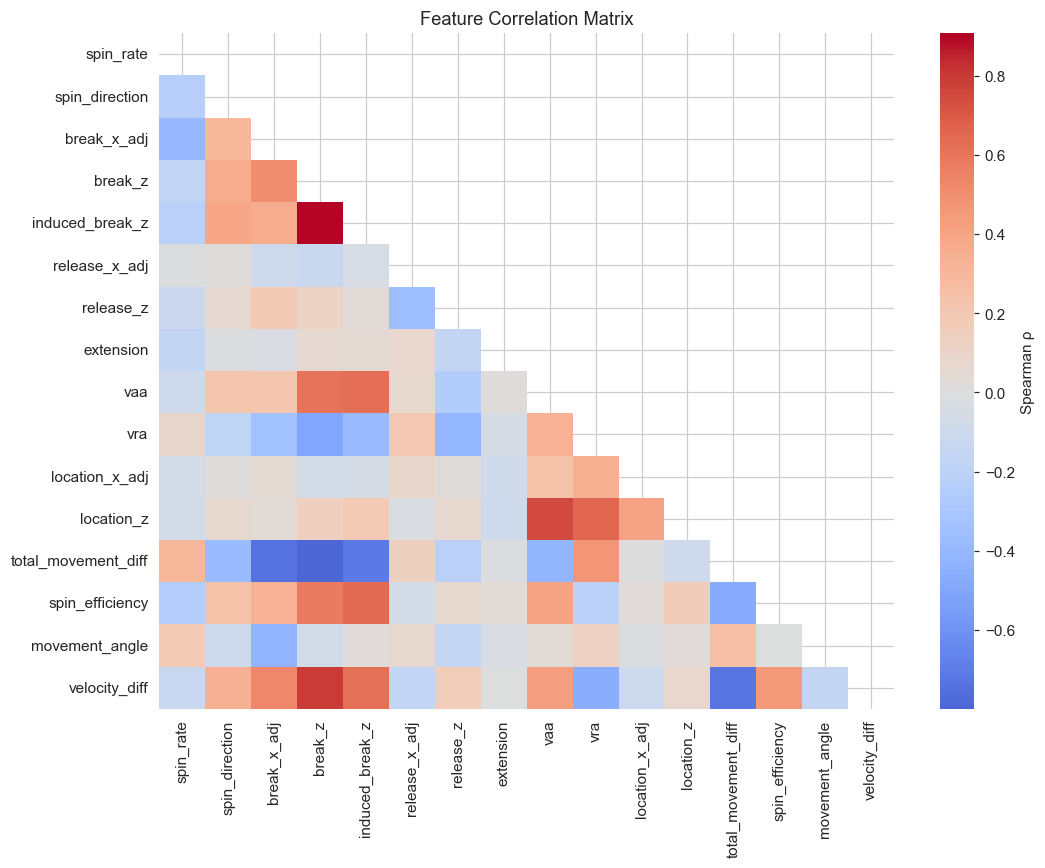

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

num_cols = [
    "spin_rate", "spin_direction", "break_x_adj", "break_z",
    "induced_break_z", "release_x_adj", "release_z",
    "extension", "vaa", "vra", "location_x_adj", "location_z",
    "total_movement_diff", "spin_efficiency", "movement_angle", "velocity_diff"
]
corr = train_df[num_cols].corr(method="spearman")  
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0,
            cbar_kws={"label": "Spearman ρ"})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

<Axes: xlabel='velocity_diff', ylabel='Count'>

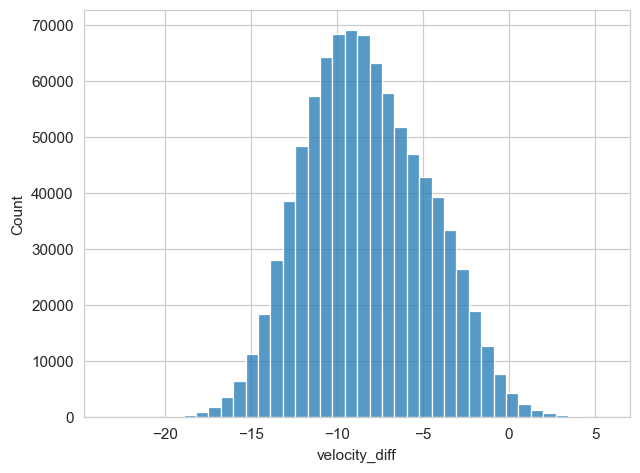

In [41]:
# Target distribution overall
sns.histplot(train_df['velocity_diff'], bins=40)

### Velocity Gap by Pitch Type

We compute the average velocity gap for each breaking ball type (vs. pitcher’s fastball). Curveballs (CB), sweepers (SW), and slurves (SV) show the largest average gaps (≈ 11–12 mph), while cutters (CT) exhibit smaller gaps. The boxplot highlights league-wide trends, with the dashed line representing the overall average gap (–8.3 mph). This supports pitch classification and informs model training.

In [43]:
# Summary stats – league‑average velocity gap by pitch type
gap_stats = (train_df.groupby("pitch_type")["velocity_diff"]
               .agg(["count", "mean", "median", "std"])
               .sort_values("mean"))
display(gap_stats)

,count,mean,median,std
pitch_type,,,,
CB,78036,-11.760543,-11.800459,2.345628
SW,115054,-11.501208,-11.457310,2.194678
SV,8247,-10.789018,-11.134195,2.491985
SL,477313,-8.741583,-8.700047,2.596748
CT,215666,-4.240758,-4.108466,2.479746


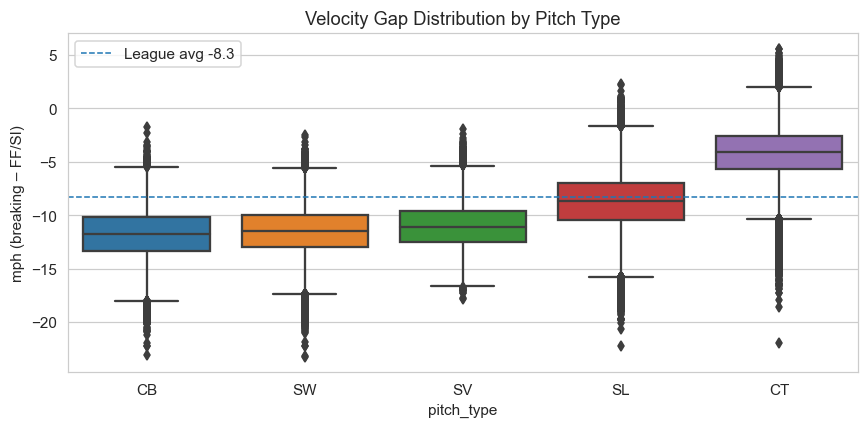

In [44]:
# Compute league-wide average velocity gap
league_mu = train_df["velocity_diff"].mean()

# Plot pitch‑type gap distribution 
plt.figure(figsize=(8,4))
sns.boxplot(x="pitch_type", y="velocity_diff", data=train_df,
            order=gap_stats.index)
plt.axhline(league_mu, ls="--", lw=1, label=f"League avg {league_mu:.1f}")
plt.title("Velocity Gap Distribution by Pitch Type")
plt.ylabel("mph (breaking – FF/SI)")
plt.legend()
plt.tight_layout()
plt.show()

### Velocity Gap vs. Movement Characteristics

These scatter plots illustrate how **horizontal break** (`break_x_adj`) and **induced vertical break** (`induced_break_z`) relate to the velocity gap across different pitch types.

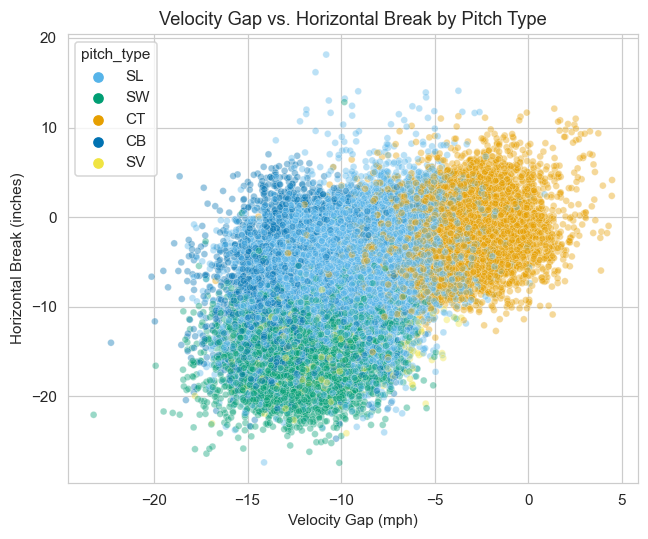

In [46]:
pitch_palette = {
    "CT": "#E69F00",
    "SL": "#56B4E9",
    "SW": "#009E73",
    "SV": "#F0E442",
    "CB": "#0072B2"
}

# Velocity gap vs movement
plt.figure(figsize=(6,5))
sns.scatterplot(data=train_df.sample(50000),
                x="velocity_diff", y="break_x_adj",
                hue="pitch_type", alpha=0.4, s=20, palette=pitch_palette)
plt.xlabel("Velocity Gap (mph)")
plt.ylabel("Horizontal Break (inches)")
plt.title("Velocity Gap vs. Horizontal Break by Pitch Type")
plt.tight_layout()
plt.show()

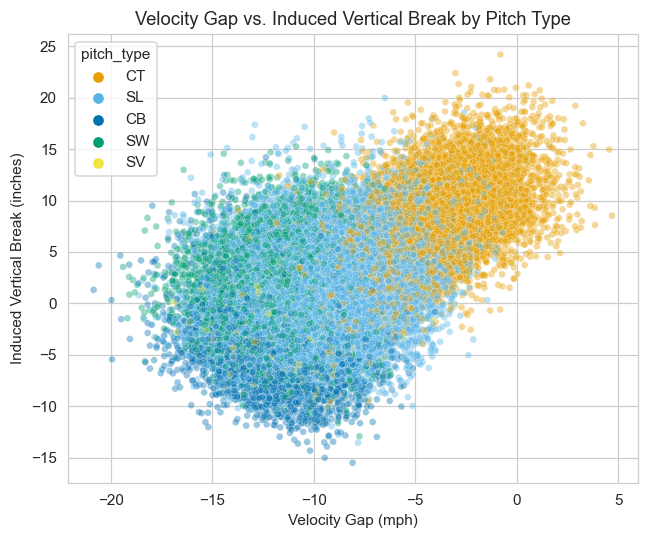

In [47]:
# Velocity Gap vs. Vertical Induced Break 
plt.figure(figsize=(6,5))
sns.scatterplot(data=train_df.sample(50000),
                x="velocity_diff", y="induced_break_z",
                hue="pitch_type", alpha=0.4, s=20, palette=pitch_palette)
plt.xlabel("Velocity Gap (mph)")
plt.ylabel("Induced Vertical Break (inches)")
plt.title("Velocity Gap vs. Induced Vertical Break by Pitch Type")
plt.tight_layout()
plt.show()

### Velocity Gap > 0 Check

From above plot, I see that some pitches velocity gap is slightly over 0. To verify data consistency, we examined all breaking pitches where the computed velocity differential (`velocity_diff`) is **greater than zero** — meaning the breaking ball was thrown faster than the pitcher's primary fastball for that season.

In [49]:
# Filter velocity_diff > 0 rows
positive_diff = train_df[train_df["velocity_diff"] > 0]

# Count every breaking ball 
pitch_type_counts = positive_diff["pitch_type"].value_counts().sort_index()

print(f"Total CT/SL/SW/SV/CB pitches with velocity_diff > 0: {len(positive_diff):,}\n")
print("Velocity Diff > 0 by Pitch Type:")
for pitch_type, count in pitch_type_counts.items():
    print(f"  {pitch_type}: {count}")

Total CT/SL/SW/SV/CB pitches with velocity_diff > 0: 7,528

Velocity Diff > 0 by Pitch Type:
  CT: 7480
  SL: 48


### Results Summary:

#### Interpretation:

* **Cutter (CT)** is frequently thrown with similar or even slightly higher velocity than a pitcher’s four-seam fastball or sinker. This is expected — cutters are typically fast breaking balls with subtle movement, designed to resemble fastballs.
* All **non-cutter** cases with `velocity_diff > 0` were exclusively **Sliders (SL)** — just **48 pitches across the entire dataset**, confirming this is an extremely rare event.

#### Decision:

Given that only **Slider** has rare positive `velocity_diff` instances — likely due to pitch classification overlap, pitch-to-pitch variation, or edge cases in defining the pitcher's fastball baseline — we **do not drop these rows**.

> The low frequency and physical plausibility of these cases do not justify removing them. Retaining them helps preserve the natural variability present in MLB pitch data.

----

### Extension Difference vs. Velocity Gap

This plot explores whether differences in release extension between breaking balls and the pitcher’s primary fastball correlate with changes in velocity gap.  
We observe a U-shaped trend: when extension closely mimics the fastball (diff ≈ 0), the velocity gap is minimized. Conversely, breaking balls thrown from notably different extension points (either shorter or longer) tend to show larger speed differentials.  
This supports the pitching theory that deception and tunnel consistency (e.g., matching extension) help reduce velocity gap and enhance pitch effectiveness.

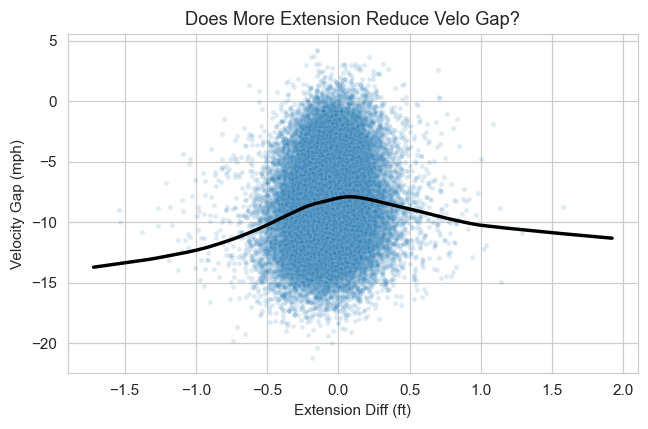

In [52]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_df.sample(40000, random_state=0),
                x="extension_diff", y="velocity_diff",
                alpha=0.15, s=10)
sns.regplot(data=train_df.sample(10000, random_state=1),
            x="extension_diff", y="velocity_diff",
            scatter=False, lowess=True, color="k")
plt.xlabel("Extension Diff (ft)")
plt.ylabel("Velocity Gap (mph)")
plt.title("Does More Extension Reduce Velo Gap?")
plt.tight_layout()
plt.show()

### Investigating Spin Efficiency and Velocity Gap

This plot examines whether higher **spin efficiency** — defined as the proportion of spin contributing to induced vertical movement — is associated with a smaller **velocity gap** between a pitcher's breaking balls and primary fastball. The trend line (LOWESS) suggests that as spin efficiency increases (up to ~0.01), the velocity gap tends to decrease, supporting the idea that more efficient spin may help disguise pitch types by reducing perceived speed differences.

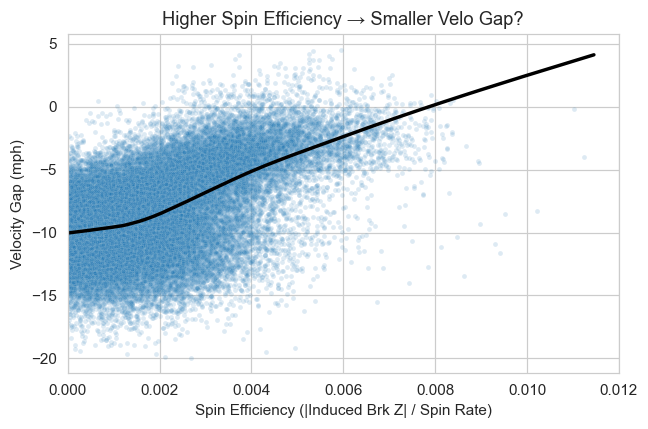

In [54]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_df.sample(40000, random_state=1),
                x="spin_efficiency", y="velocity_diff",
                alpha=0.15, s=10)

sns.regplot(data=train_df[train_df["spin_efficiency"] < 0.05].sample(10000, random_state=2),
            x="spin_efficiency", y="velocity_diff",
            scatter=False, lowess=True, color="k")

plt.xlim(0, 0.012)
# plt.xscale("log")
plt.xlabel("Spin Efficiency (|Induced Brk Z| / Spin Rate)")
plt.ylabel("Velocity Gap (mph)")
plt.title("Higher Spin Efficiency → Smaller Velo Gap?")
plt.tight_layout()
plt.show()

---

## 3. Modeling Approach & Validation Overview

We trained and compared five different models to balance **predictive performance**, **interpretability**, and **alignment with baseball intuition**:

### Modeling Workflow (Step-by-step)

1. **Data Splitting**
   - Hold out 2024-only unseen pitchers as test set.
   - Use GroupKFold CV on the rest (grouped by `pitcher_id`).

2. **Training Pipeline**
   - Unified pipeline with preprocessing + model
   - Evaluation based on MAE, RMSE, and R² (CV + holdout)

3. **Model Selection Rationale**

   #### Linear Models (Interpretability & Baseline)

   - **Linear Regression**  
     A simple, interpretable baseline to understand core signal in the data.

   - **Ridge Regression (L2)**  
     Handles multicollinearity and stabilizes predictions with regularization.  
     Chosen for its **balance between performance and interpretability**.

   - **Lasso Regression (L1)**  
     Introduced for **automatic feature selection**, helpful for identifying redundant variables.  
     Also used to test model sparsity vs. performance trade-offs.

   #### Boosting Models (Non-linear Learning Power)

   - **XGBoost**  
     Widely used in tabular modeling; captures complex non-linear interactions.  
     Ideal for exploring whether velocity differential involves subtle feature combinations.  
     Tuned manually for stability and generalization.

   - **LightGBM**  
     Efficient gradient boosting alternative to XGBoost.  
     Included to test whether a **lighter/faster implementation** could match or exceed XGBoost.  
     Same tuning principles applied.

> These five models represent a diverse mix of linear vs. non-linear approaches,  
> with the goal of finding the best trade-off between **performance**, **explainability**, and **practical value for coaches and analysts**.

In [56]:
# Machine learning imports
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
os.makedirs("models", exist_ok=True)

### Data Splitting & Cross-Validation Strategy

To ensure robust and pitcher-aware evaluation, we split the dataset with two goals in mind:  
1) simulate **predicting for completely new pitchers**, and  
2) maximize usage of known data for training.

#### 1. Holdout Set: Unseen Pitchers from 2024

We constructed a **holdout test set** (`X_hold`, `y_hold`) using **only pitchers who appear in the 2024 season but never appear in the training data from 2020–2023**.

- This simulates predicting velocity differentials for **new or recently debuted pitchers**, as would happen in real MLB analytics work.
- All other 2024 data (i.e., from pitchers we've seen in earlier years) is **reintegrated into the training set** to improve learning.

#### 2. Training Set: Known Pitchers (2020–2023 + familiar 2024)

The training set (`X_train`, `y_train`) includes:

- All pitches from the 2020–2023 seasons
- Plus 2024 pitches from pitchers who **already appeared** between 2020–2023

This design maximizes the training signal while preserving a **clean evaluation split** between known and unknown pitchers.

#### Group K-Fold Cross-Validation (by Pitcher ID)

To evaluate model generalization within the training set, we use **5-fold GroupKFold**, where:

- Each fold holds out all pitches from a subset of pitchers
- Ensures that no pitcher's data leaks between training and validation
- Mirrors the deployment reality of applying models to **new pitchers**
Grouping key: `pitcher_id`

I emphasize **honest evaluation and deployment-aligned strategy** — critical for high-stakes, data-driven baseball decision making.

In [58]:
# Copy the preprocessed DataFrame
model_df = train_df.copy()

# Binary-label encode 'throws' and 'half_inning' to integers 0/1
# Using 0/1 reduces one-hot dimensionality for simple binary features
model_df['throws'] = (model_df['throws'] == 'L').astype(int)           # 'L' → 1, 'R' → 0
model_df['half_inning'] = (model_df['half_inning'] == 'Bottom').astype(int)  # 'Bottom' → 1, 'Top' → 0

# Split data into training (2020–2023) and holdout (2024)
train_full = model_df[model_df['season'] < 2024].copy()  # All seasons before 2024
holdout = model_df[model_df['season'] == 2024].copy()    # Season 2024 only

# Exclude pitchers seen in training from the holdout set
# Ensures holdout tests on new pitchers only
seen_pitchers = train_full['pitcher_id'].unique()
holdout = holdout[~holdout['pitcher_id'].isin(seen_pitchers)]

# Add the pithchers that is seen back to the training data for modeling
seen_2024 = model_df[
    (model_df['season'] == 2024) &
    (model_df['pitcher_id'].isin(seen_pitchers))
]
train_full = pd.concat([train_full, seen_2024], ignore_index=True)

print(f"train_full: {train_full['pitcher_id'].nunique():,} pitchers, {len(train_full):,} rows")
print(f"holdout:    {holdout['pitcher_id'].nunique():,} pitchers, {len(holdout):,} rows")

train_full: 1,161 pitchers, 865,320 rows
holdout:    149 pitchers, 28,996 rows


In [59]:
# Separate features (X) and target (y) for train and holdout
# Drop identifiers and target from feature sets
X_train = train_full.drop(columns=['pitcher_id', 'season', 'velocity_diff'])
y_train = train_full['velocity_diff']
groups = train_full['pitcher_id']  # Group labels for splitting

X_hold = holdout.drop(columns=['pitcher_id', 'season', 'velocity_diff'])
y_hold = holdout['velocity_diff']

In [60]:
# Identify numeric and categorical features for preprocessing
numeric_features = [col for col in X_train.columns if col != 'pitch_type']
categorical_features = ['pitch_type']

# Scale numeric features to zero mean and unit variance
# One-hot encode pitch_type, ignoring unknown categories
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), numeric_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Model Training & Evaluation Function

This helper function performs:

- Pipeline setup (preprocessing + model)
- 5-fold GroupKFold cross-validation (by pitcher)
- GridSearchCV hyperparameter tuning (optional)
- CV metrics: MAE, RMSE, R² (averaged manually)
- Final evaluation on 2024 holdout set (unseen pitchers)
- Best model saved as `.joblib` for deployment or analysis

In [62]:
# Initialize GroupKFold to avoid leakage of the same pitcher across folds
gkf = GroupKFold(n_splits=5)

# Helper function: fit, cross-validate, and evaluate on holdout
def fit_and_evaluate(name, estimator, param_grid, early_stop=False):
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', estimator)
    ])
    
    # Setup GroupKFold
    cv = GroupKFold(n_splits=5)
    cv_splits = cv.split(X_train, y_train, groups)
    
    # Setup GridSearchCV
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_splits,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
    )

    # Handle early stopping params if needed
    fit_params = {}
    if early_stop:
        fit_params = {
            "model__eval_set": [(X_hold, y_hold)],
            "model__early_stopping_rounds": 25,
            "model__verbose": False
        }

    # Fit the model
    grid.fit(X_train, y_train, **fit_params)

    # Report best results
    best_model = grid.best_estimator_
    cv_mae = -grid.best_score_
    
    # Compute CV RMSE manually 
    cv_rmse_list = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = clone(best_model)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        cv_rmse_list.append(val_rmse)
    avg_cv_rmse = np.mean(cv_rmse_list)

    # Compute CV R² manually
    cv_r2_list = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = clone(best_model)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        val_r2 = r2_score(y_val, y_val_pred)
        cv_r2_list.append(val_r2)
    avg_cv_r2 = np.mean(cv_r2_list)

    print(f"{name} CV MAE: {cv_mae:.3f}, CV RMSE: {avg_cv_rmse:.3f}, CV R²: {avg_cv_r2:.3f} (best_params={grid.best_params_})")

    # Holdout evaluation
    y_pred = best_model.predict(X_hold)
    hold_mae = mean_absolute_error(y_hold, y_pred)
    hold_rmse = np.sqrt(mean_squared_error(y_hold, y_pred))
    hold_r2 = r2_score(y_hold, y_pred)
    print(f"{name} Holdout MAE: {hold_mae:.3f}, RMSE: {hold_rmse:.3f}, R²: {hold_r2:.3f}")

    # Save model
    model_path = f"models/best_model_{name.replace(' ', '_').lower()}.joblib"
    joblib.dump(best_model, model_path)
    print(f"{name} model saved to {model_path}\n")

### 1. Baseline Model: Linear Regression
Using a standard Linear Regression model as the baseline to compare against regularized methods.

### 2. Regularized Model: Ridge Regression (L2)
Applies L2 penalty to reduce overfitting and handle multicollinearity, with alpha tuned via GridSearch.

### 3. Regularized Model: Lasso Regression (L1)
Applies L1 penalty for both regularization and feature selection. May zero out less informative features.

In [64]:
# Baseline: Linear Regression (no hyperparameters)
fit_and_evaluate(
    name='LinearRegression',
    estimator=LinearRegression(),
    param_grid={}  
)

# Regularized linear models: Ridge & Lasso
fit_and_evaluate(
    name='Ridge',
    estimator=Ridge(random_state=42),
    param_grid={'model__alpha': [0.1, 1.0, 10.0]}  # L2 regularization strengths
)
fit_and_evaluate(
    name='Lasso',
    estimator=Lasso(random_state=42, max_iter=10000, tol=1e-2, selection="random"),
    param_grid={'model__alpha': [0.001, 0.01, 0.1]}  # L1 regularization strengths
)

LinearRegression CV MAE: 0.302, CV RMSE: 0.425, CV R²: 0.986 (best_params={})
LinearRegression Holdout MAE: 0.310, RMSE: 0.507, R²: 0.980
LinearRegression model saved to models/best_model_linearregression.joblib

Ridge CV MAE: 0.302, CV RMSE: 0.425, CV R²: 0.986 (best_params={'model__alpha': 0.1})
Ridge Holdout MAE: 0.310, RMSE: 0.506, R²: 0.980
Ridge model saved to models/best_model_ridge.joblib

Lasso CV MAE: 0.476, CV RMSE: 0.615, CV R²: 0.970 (best_params={'model__alpha': 0.001})
Lasso Holdout MAE: 0.492, RMSE: 0.688, R²: 0.963
Lasso model saved to models/best_model_lasso.joblib



### 4. Gradient Boosting Model: XGBoost
Tree-based model using additive boosting to capture non-linear relationships. 
Uses `reg:squarederror` as the objective with regularization (`reg_alpha`, `reg_lambda`) and subsampling to prevent overfitting.

### 5. Gradient Boosting Model: LightGBM
Efficient boosting model optimized for speed and performance. 
Configured similarly to XGBoost with early stopping disabled and moderate regularization applied.

#### Why No Grid Search for XGBoost & LightGBM

Initial runs with `GridSearchCV` showed **minimal gains** and occasionally **higher variance** on validation scores.
Instead, I applied well-established best practices for boosting models—tuning `max_depth`, `learning_rate`, `subsample`, and regularization manually.
These fixed settings provided **more consistent performance** and avoided unnecessary overfitting.

In [66]:
# Gradient boosting model: XGBoost
fit_and_evaluate(
    name="XGBoost",
    estimator=XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        n_estimators=1000,
        max_depth=6,                
        learning_rate=0.05,         
        subsample=0.8,             
        colsample_bytree=0.8,       
        reg_alpha=0.1,            
        reg_lambda=1.0,            
        random_state=42,
        n_jobs=-1
    ),
    param_grid={},  
    early_stop=False
)

# Gradient boosting model: LightGBM
fit_and_evaluate(
    name="LightGBM",
    estimator=LGBMRegressor(
        objective="regression",
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1 
    ),
    param_grid={},  
    early_stop=False
)

XGBoost CV MAE: 0.985, CV RMSE: 1.258, CV R²: 0.875 (best_params={})
XGBoost Holdout MAE: 0.902, RMSE: 1.195, R²: 0.889
XGBoost model saved to models/best_model_xgboost.joblib

LightGBM CV MAE: 1.002, CV RMSE: 1.278, CV R²: 0.871 (best_params={})
LightGBM Holdout MAE: 0.913, RMSE: 1.208, R²: 0.886
LightGBM model saved to models/best_model_lightgbm.joblib



### Full Metric Comparison Table

| Model             | CV MAE | CV RMSE | CV R²  | Holdout MAE | Holdout RMSE | Holdout R² |
|------------------|--------|---------|--------|--------------|----------------|-------------|
| Linear Regression | 0.302  | 0.425   | 0.986  | 0.310        | 0.507          | 0.980       |
| Ridge             | 0.302  | 0.425   | 0.986  | 0.310        | 0.506          | 0.980       |
| Lasso             | 0.476  | 0.615   | 0.970  | 0.492        | 0.688          | 0.963       |
| XGBoost           | 0.985  | 1.258   | 0.875  | 0.902        | 1.195          | 0.889       |
| LightGBM          | 1.002  | 1.278   | 0.871  | 0.913        | 1.208          | 0.886       |


---

## 4. Model Interpretation Overview

This notebook presents three key analyses to evaluate and interpret model behavior:

1. **Top 15 Most Influential Features (Ridge Coefficients)**  
   Identify the most important linear predictors and explain them using baseball context.

2. **SHAP Summary: Feature Impact in XGBoost**  
   Visualize and interpret non-linear feature contributions using SHAP values.

3. **Error Analysis by Pitch Type & Velocity Differential**  
   Diagnose model biases across pitch types and velocity bins using full-dataset heatmaps.

### Top 15 Most Influential Features (Ridge Coefficients)

This cell extracts the top 15 features (by absolute coefficient magnitude) from the trained Ridge Regression model.  
Each feature is matched with a baseball-specific interpretation to help understand how it contributes to the predicted velocity differential.

In [70]:
# Load trained Ridge model and extract pipeline components
ridge_model = joblib.load("models/best_model_ridge.joblib")
preprocessor = ridge_model.named_steps["pre"]
ridge = ridge_model.named_steps["model"]

# Extract full feature names after preprocessing
numeric_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.transformers_[1][1]
categorical_features = cat_encoder.get_feature_names_out(["pitch_type"])
feature_names = np.concatenate([numeric_features, categorical_features])

# Create DataFrame of coefficients
coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": ridge.coef_
    })
    .assign(abs_coef=lambda df: df["coef"].abs())
    .sort_values("abs_coef", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

# Add baseball interpretation to each feature (optional)
feature_notes = {
    "haa_adj": "Horizontal approach angle (adjusted)",
    "break_x_diff": "Horizontal break difference (vs fastball)",
    "haa_diff": "Horizontal approach angle difference",
    "break_x_adj": "Horizontal break (adjusted)",
    "hra_adj": "Vertical approach angle (adjusted)",
    "hra_diff": "Vertical approach angle difference",
    "vaa": "Vertical approach angle",
    "break_z": "Vertical break (raw)",
    "vaa_diff": "Vertical approach angle difference",
    "location_z_diff": "Vertical location difference (vs fastball)",
    "vra": "Vertical release angle",
    "location_z": "Vertical pitch location",
    "induced_break_z_diff": "Induced vertical break difference (vs fastball)",
    "location_x_adj": "Horizontal location (adjusted)",
    "location_x_diff": "Horizontal location difference (vs fastball)"
}
coef_df["baseball_note"] = coef_df["feature"].map(feature_notes).fillna("—")

# Display result
print("Top 15 Ridge Coefficients with Interpretation:")
print(coef_df)

Top 15 Ridge Coefficients with Interpretation:
                 feature       coef   abs_coef                                    baseball_note
0                haa_adj -57.906351  57.906351             Horizontal approach angle (adjusted)
1           break_x_diff -55.129980  55.129980        Horizontal break difference (vs fastball)
2               haa_diff  54.097803  54.097803             Horizontal approach angle difference
3            break_x_adj  41.848410  41.848410                      Horizontal break (adjusted)
4                hra_adj  41.058183  41.058183               Vertical approach angle (adjusted)
5               hra_diff -39.886218  39.886218               Vertical approach angle difference
6                    vaa -31.520377  31.520377                          Vertical approach angle
7                break_z  22.798666  22.798666                             Vertical break (raw)
8               vaa_diff  19.701361  19.701361               Vertical approach angle diff

### Interpretation: What the Top 15 Ridge Coefficients Reveal

The top features from the Ridge Regression model align closely with established pitching mechanics and pitch design principles:

#### Key Takeaways

- **Horizontal Approach Angle (HAA) & Break X**  
  The most influential features are `haa_adj`, `haa_diff`, and `break_x_diff`, all related to the **horizontal movement and entry angle** of the pitch. (Since haa_diff = breaking_ball_haa_adj – fastball_haa_adj is typically negative, a positive coefficient implies that when the horizontal approach angle becomes more similar to the fastball (i.e., haa_diff increases toward zero), the model predicts a smaller velocity gap — consistent with the tunneling effect.)

  
  ➤ This confirms that pitchers who generate more **horizontal separation** from their fastballs (e.g., big sweepers) tend to create larger perceived velocity differentials — a well-known pitch design goal.

- **Vertical Movement & Approach**  
  Features like `hra_adj`, `hra_diff`, `vaa`, `vaa_diff`, and `break_z` reflect **vertical movement and descent angle**, indicating that **inducing vertical drop or a steep descent angle** contributes significantly to how "slow" a pitch feels to hitters.

- **Location & Tunnel Separation**  
  Several top features involve **location differences from the fastball** (`location_z_diff`, `location_x_diff`) or raw locations (`location_z`, `location_x_adj`), suggesting that **how well the breaking pitch "tunnels"** with the fastball affects how large the velocity gap appears.

#### Baseball Insight

These results support the concept that **velocity differential is not just about speed — it’s about movement shape, entry angle, and deception**.  
In modern pitch design, optimizing *movement differentials* while maintaining similar arm slots and tunnels is a key strategy.  
The model captures this intuition quantitatively, giving coaches and analysts a transparent way to assess whether a pitch’s shape truly supports its intended speed differential.

-----

### SHAP Summary: Feature Impact in XGBoost

To understand which features most influence predictions in the XGBoost model, we use SHAP (SHapley Additive exPlanations) to generate a global summary plot. This helps verify if the model is learning meaningful baseball-related patterns and whether the important features align with domain knowledge.

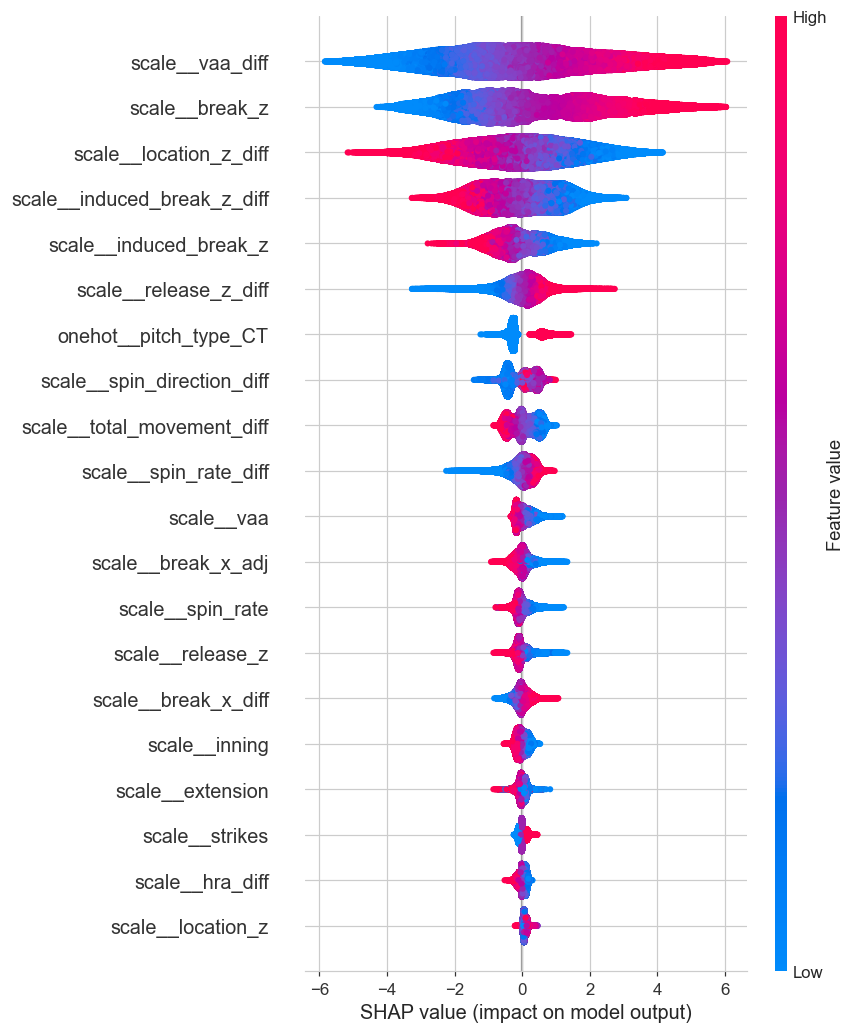

In [73]:
import shap

# Load trained XGBoost model
xgb_model = joblib.load("models/best_model_xgboost.joblib")

# Use Ridge model's preprocessor to transform the input features
X_transformed = ridge_model.named_steps['pre'].transform(X_train)
feature_names = ridge_model.named_steps["pre"].get_feature_names_out()

# Initialize SHAP TreeExplainer for XGBoost)
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])
shap_values = explainer.shap_values(X_transformed)

# Generate SHAP summary plot to visualize global feature impact
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

### SHAP Summary Plot (XGBoost)

This SHAP summary plot visualizes the **global feature importance** in the trained XGBoost model.

- Each row represents a feature, ordered by **average impact on the model's output**.
- Each dot represents a single pitch, with its SHAP value (horizontal) showing **how much that pitch’s feature value pushed the prediction higher or lower**.

#### Key Observations

- The most impactful features include:
  - `vaa_diff` (vertical approach angle difference)
  - `break_z` (vertical break)
  - `location_z_diff` (vertical location difference vs fastball)

These features suggest that **vertical components of pitch shape and location** are key drivers of predicted velocity differential in XGBoost.

#### Why Do These Differ from Ridge Top Features?

While Ridge Regression emphasized **horizontal movement features** like `haa_diff`, `break_x_diff`, and `break_x_adj`, XGBoost gives more weight to **vertical movement and release-based factors**.

This difference arises because:

- **Ridge assumes linear relationships** and captures strong additive signals (like consistent horizontal separation).
- **XGBoost captures non-linear and interaction effects**, which may explain why it surfaces vertical factors that interact with other features (e.g., vertical drop varying with release point).


#### My Insight

The two models **complement each other**:  
- Ridge gives a **transparent, baseline understanding** rooted in additive relationships.  
- XGBoost offers a **richer view of non-linear interactions**, useful for deeper pitch design analysis.

Together, they help validate which features matter most — and how those features affect perception of pitch speed.

------

### Error Analysis by Pitch Type & Velocity Differential

To better understand how model prediction errors vary across pitch types and true velocity differential bins,  
we use the **entire dataset (2020–2024, including both training and holdout pitchers)** to generate detailed heatmaps.

For each model, we:

- Predict `velocity_diff` on all available data
- Bin the **true velocity differential** into mph ranges (e.g., -17 to -14)
- Group by **pitch type × velocity differential bin**
- Visualize the **average prediction error** in each group

This helps us identify:

- Which pitch types are harder to predict accurately
- Where models tend to **over- or under-predict** in specific velocity ranges
- Systematic bias patterns (e.g., "model consistently over-predicts low-speed curveballs")

These insights are valuable for both **model refinement** and **communicating to coaches** where predictions may need calibration.

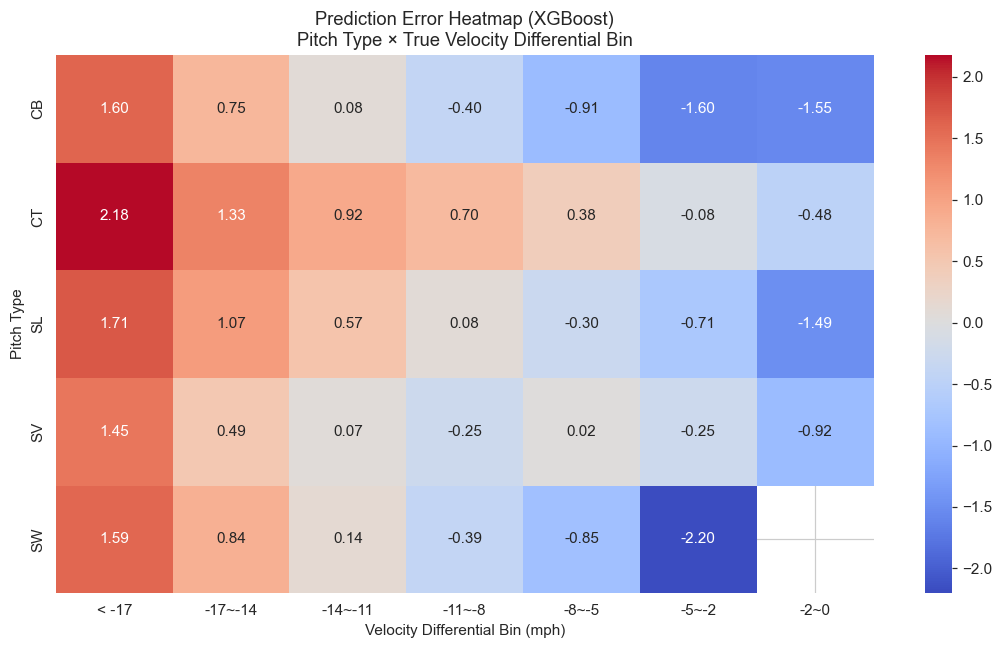

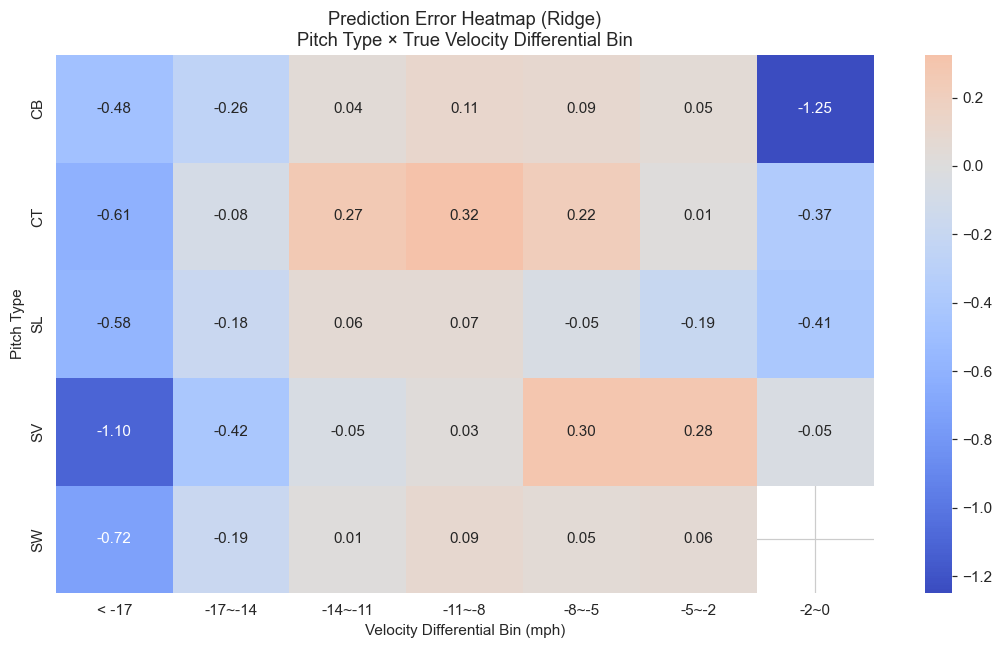

In [76]:
def plot_error_heatmap(model, model_name):
    # Drop identifier and target columns to get feature matrix
    X_all = model_df.drop(columns=["pitcher_id", "season", "velocity_diff"])
    y_all = model_df["velocity_diff"]

    # Apply preprocessing if the model is a pipeline (e.g., Ridge)
    if hasattr(model, "named_steps"):  # typically Ridge or Lasso pipeline
        X_transformed = model.named_steps["pre"].transform(X_all)
        y_pred = model.predict(X_all)
    else:  # for models like XGBoost where preprocessing is handled separately
        y_pred = model.predict(X_all)

    # Compute prediction errors
    errors = y_pred - y_all.values

    # Create a new DataFrame with errors and true values for analysis
    heatmap_df = model_df.copy()
    heatmap_df["prediction_error"] = errors
    heatmap_df["true_velocity_diff"] = y_all.values

    # Bin the true velocity differential into predefined mph ranges
    heatmap_df["diff_bin"] = pd.cut(
        heatmap_df["true_velocity_diff"],
        bins=[-20, -17, -14, -11, -8, -5, -2, 0],
        right=False,
        labels=["< -17", "-17~-14", "-14~-11", "-11~-8", "-8~-5", "-5~-2", "-2~0"]
    )

    # Create a pivot table: average prediction error for each pitch type and diff_bin
    pivot = heatmap_df.pivot_table(
        index="pitch_type",
        columns="diff_bin",
        values="prediction_error",
        aggfunc="mean"
    )

    # Visualize the result using a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(f"Prediction Error Heatmap ({model_name})\nPitch Type × True Velocity Differential Bin")
    plt.xlabel("Velocity Differential Bin (mph)")
    plt.ylabel("Pitch Type")
    plt.tight_layout()
    plt.show()

# Generate heatmaps for both models
plot_error_heatmap(xgb_model, "XGBoost")
plot_error_heatmap(ridge_model, "Ridge")

### Conclusion: Error Distribution Comparison (XGBoost vs Ridge)

By comparing the **prediction error heatmaps** across pitch types and true velocity differential bins, we observe clear differences in model behavior:

#### XGBoost (Top)
- Shows **large over-predictions** (positive errors) for low-speed pitches, especially for cutters (CT) and sliders (SL) in the `< -11 mph` range.
- Tends to **under-predict** (negative errors) in moderate to higher-speed bins (e.g., `-8~0`), especially for curveballs (CB) and sweepers (SW).
- The model appears more sensitive to extreme cases but also more erratic.

#### Ridge Regression (Bottom)
- Errors are **centered closer to zero**, showing better calibration across most pitch types and bins.
- Has **smaller absolute errors**, particularly in bins like `-11~-8` and `-8~-5`.
- While slightly under-predicting extreme low-speed pitches, the Ridge model maintains **more stable and consistent predictions** across the board.

#### Final Takeaway
Despite its simplicity, **Ridge Regression not only delivers better overall accuracy**, but also maintains **balanced and interpretable error behavior** across pitch types and velocity bands. This supports our conclusion that Ridge is the **more reliable and trustworthy model** for real-world application in this task.

---------------

## Final Model Comparison & Conclusion

We evaluated five models across both cross-validation (GroupKFold by pitcher) and a strict holdout test set (unseen 2024 pitchers).  
Metrics include MAE, RMSE, and R². Results are shown below.

### Key Observations

- **Linear Regression & Ridge Regression** delivered the **lowest error** (MAE ≈ 0.30) and **highest R²** (~0.98), on both CV and holdout.
- **Lasso Regression** underperformed slightly, likely due to over-pruning useful features.
- **XGBoost & LightGBM**, despite being powerful non-linear learners, performed worse (MAE > 0.9), indicating diminishing returns on complexity.


### Best Model: **Ridge Regression**

Ridge Regression emerged as the best overall model, not only for its accuracy but also its transparency and stability.  
It provides interpretable coefficients that align with known baseball principles (e.g., horizontal break, approach angle).

> Importantly, this performance advantage stems from **strong domain-driven feature engineering**:

- By engineering **differential features** (e.g., `break_x_diff`, `vaa_diff`, `location_z_diff`),  
  we effectively **linearized many of the physical relationships** that govern pitch deception.
- These additive, structured features made the task ideal for **regularized linear models**, allowing Ridge to outperform complex tree-based models.

Thus, Ridge strikes the best balance between:

-  Predictive accuracy  
-  Interpretability for coaches and analysts
-  Generalization to new pitchers

We recommend Ridge Regression as the **primary model** for evaluating and deploying velocity differential predictions in a real-world MLB analytics workflow.


This confirms that **thoughtful preprocessing and physics-aligned features** can allow even simple models to deliver exceptional results —  
a valuable lesson for both modeling and practical deployment in baseball analytics.


------------
#### Predictions on 2024 Unseen Pitchers  
This file contains Ridge model predictions for **2024-season pitchers who were not seen during 2020–2023 training**, simulating real-world generalization to new arms.

In [124]:
y_pred = ridge_model.predict(X_hold)
output = holdout[["pitcher_id", "season", "velocity_diff"]].copy()
output["predicted_velocity_diff"] = y_pred
output.to_csv("predictions_not_seen_pitchers_2024.csv", index=False)
print("Saved to predictions_not_seen_pitchers_2024.csv")

Saved to predictions_not_seen_pitchers_2024.csv
